#### https://changhoonhahn.github.io/code.html

#### http://skiesanduniverses.org/Simulations/GLAM/

#### https://arxiv.org/pdf/1907.08094.pdf

In [11]:
import numpy as np
from numpy.linalg import inv,det
import matplotlib.pyplot as plt
from itertools import permutations
from scipy.interpolate import RegularGridInterpolator as rgi
import scipy.interpolate as interpolate
from scipy.interpolate import LinearNDInterpolator as lndi
from scipy import integrate
from scipy.optimize import curve_fit


import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from my_utils.utils import Bi0,Bisp

import pandas as pd
import scipy.stats
import math

from tqdm import tqdm
import time
import emcee                    # for MCMC part
import corner                   # for plotting the contours
import warnings                 # for ignoring the warnings (not recommended)
warnings.filterwarnings('ignore')

In [12]:
Bk=np.load("../Molino_mocks/bk_molino_z0.npz")
Pk=np.load("../Molino_mocks/pk_molino_z0.npz")
k,pk0,pk2,pk4=Pk['k'], Pk['pk0'], Pk['pk2'], Pk['pk4']
kk,bk0,bk2,bk4=Bk['kk'], Bk['bk0'], Bk['bk2'], Bk['bk4']
# pknm=np.mean(pk0,axis=1)
# bknm=np.mean(bk0,axis=1)
#pk_mol=pk0
bk_mol=bk0

In [48]:
Bk=np.load("../GLAM_Bi/bk_z0.50.npz")
Pk=np.load("../GLAM_Ps/pk_z0.50.npz")
k,pkm,pknm,pk,pkn=Pk['k'], Pk['pkm'].T[0],Pk['pknm'].T[0],Pk['pk'],Pk['pkn']
kk,bkm,bknm,bk,bkn=Bk['k'], Bk['bkm'].T[0], Bk['bknm'].T[0],Bk['bk'],Bk['bkn']

In [ ]:
def get_cov(y_molino, y_glam, plot=False):
    
    cov_ = np.cov(y_molino, rowvar=0)
    std_ = np.diagonal(cov_)**0.5
    rcov = cov_ / np.outer(std_, std_)
    std = np.std(y_glam, axis=0)
    cov = rcov * np.outer(std, std)
      
    return cov

In [57]:
kmin=0.1
kmax=0.2
def cutslice(kmin,kmax,kk,bkm,bk,bk_mol):
    is_good = np.ones(kk.shape[0], '?')
    for i in range(3):is_good &= (kk[:, i] > kmin) & (kk[:, i] < kmax)
    kg = kk[is_good, :]
    bg = bkm[is_good]
    #bgn = bknm[is_good]
    nbins, nmocks = bkn[is_good, :].shape
    hartlapf = (nmocks-1.0)/(nmocks-nbins-2.0)
    glam_cov = np.cov(bk[is_good, :], rowvar=True)#/ nmocks
    # covn = np.cov(bkn[is_good, :], rowvar=True)#/ nmocks
    # covw = np.cov(bk[is_good, :]/bkn[is_good, :], rowvar=True)#/ nmocks
     
    glam_std = np.std(bk[is_good], axis=1)         
    mol_cov_ = np.cov(bk_mol[is_good,:], rowvar=True)
    mol_std_ = np.diagonal(mol_cov_)**0.5

    red_cov = mol_cov_/np.outer(mol_std_, mol_std_)
    scaled_cov = red_cov*np.outer(glam_std, glam_std)
        
    #icov = inv(cov)
    #icovn = inv(covn)
    print(f'kmax={kmax}, kmin={kmin}, nbins={nbins}, nmocks={nmocks}, hf = {hartlapf}')
    return kg,bg,glam_cov,scaled_cov,hartlapf

In [58]:
hf=[]
for j in reversed(np.unique(kk[:,0])[3:]):
    _,_,_,_,h=cutslice(0,j,kk,bkm,bk,bk_mol)
    hf.append(h)

kmax=0.295, kmin=0, nbins=2360, nmocks=922, hf = -0.6395833333333333
kmax=0.285, kmin=0, nbins=2135, nmocks=922, hf = -0.7580246913580246
kmax=0.275, kmin=0, nbins=1925, nmocks=922, hf = -0.9164179104477612
kmax=0.265, kmin=0, nbins=1729, nmocks=922, hf = -1.138442521631644
kmax=0.255, kmin=0, nbins=1547, nmocks=922, hf = -1.4688995215311005
kmax=0.245, kmin=0, nbins=1378, nmocks=922, hf = -2.010917030567686
kmax=0.235, kmin=0, nbins=1222, nmocks=922, hf = -3.0496688741721854
kmax=0.225, kmin=0, nbins=1078, nmocks=922, hf = -5.829113924050633
kmax=0.215, kmin=0, nbins=946, nmocks=922, hf = -35.42307692307692
kmax=0.205, kmin=0, nbins=825, nmocks=922, hf = 9.694736842105263
kmax=0.195, kmin=0, nbins=715, nmocks=922, hf = 4.492682926829269
kmax=0.185, kmin=0, nbins=615, nmocks=922, hf = 3.019672131147541
kmax=0.175, kmin=0, nbins=525, nmocks=922, hf = 2.331645569620253
kmax=0.165, kmin=0, nbins=444, nmocks=922, hf = 1.934873949579832
kmax=0.155, kmin=0, nbins=372, nmocks=922, hf = 1.6806

In [116]:
kg,bg,glam_cov,scaled_cov,_=cutslice(0.015,0.3,kk,bkm,bk,bk_mol)

kmax=0.3, kmin=0.015, nbins=2513, nmocks=922, hf = -0.5781544256120528


In [117]:
glam_cov

array([[ 4.34599574e+08,  7.03829145e+06, -2.28524347e+06, ...,
        -6.75517411e+02,  1.41279136e+03,  1.47982403e+03],
       [ 7.03829145e+06,  7.05095751e+07, -1.87699913e+06, ...,
        -1.12449722e+03, -1.88093113e+02, -2.93183423e+02],
       [-2.28524347e+06, -1.87699913e+06,  4.20235700e+07, ...,
         2.51026806e+02, -1.26992252e+02, -1.63329356e+03],
       ...,
       [-6.75517411e+02, -1.12449722e+03,  2.51026806e+02, ...,
         1.41102820e+01, -4.84363120e-02, -6.54219088e-01],
       [ 1.41279136e+03, -1.88093113e+02, -1.26992252e+02, ...,
        -4.84363120e-02,  1.20095630e+01, -2.30243447e+00],
       [ 1.47982403e+03, -2.93183423e+02, -1.63329356e+03, ...,
        -6.54219088e-01, -2.30243447e+00,  3.64632722e+01]])

In [118]:
scaled_cov

array([[4.34128207e+08, 1.11664805e+07, 1.62185397e+07, ...,
        2.61431924e+03, 2.25633114e+03, 3.08432706e+03],
       [1.11664805e+07, 7.04331005e+07, 7.66657605e+06, ...,
        1.74279430e+03, 1.64471046e+03, 2.34894420e+03],
       [1.62185397e+07, 7.66657605e+06, 4.19779913e+07, ...,
        1.60245649e+03, 1.47383477e+03, 2.44615084e+03],
       ...,
       [2.61431924e+03, 1.74279430e+03, 1.60245649e+03, ...,
        1.40949780e+01, 5.37773080e+00, 5.45737019e+00],
       [2.25633114e+03, 1.64471046e+03, 1.47383477e+03, ...,
        5.37773080e+00, 1.19965374e+01, 6.60467479e+00],
       [3.08432706e+03, 2.34894420e+03, 2.44615084e+03, ...,
        5.45737019e+00, 6.60467479e+00, 3.64237241e+01]])

In [119]:
glam_inv=np.linalg.pinv(glam_cov,rcond=1e-5, hermitian=True)

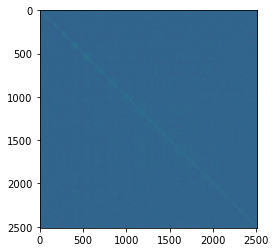

In [120]:
plt.imshow(np.corrcoef(glam_inv))

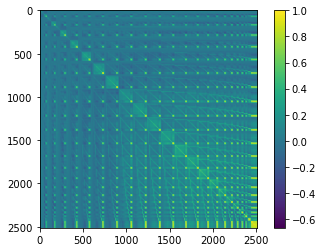

In [124]:
scaled_inv=np.linalg.pinv(scaled_cov,rcond=1e-5, hermitian=True)
plt.imshow(np.corrcoef(scaled_inv))
plt.colorbar()
plt.show()

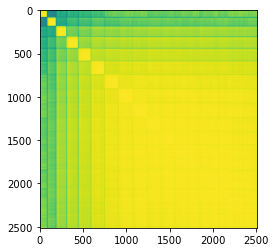

In [122]:
plt.imshow(np.corrcoef(scaled_cov))

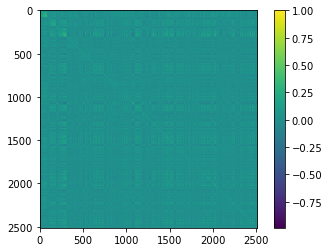

In [123]:
plt.imshow(np.corrcoef(glam_cov))
plt.colorbar()

In [32]:
def Bi_wiggle(kk,f,b1,b2):
    B_full=Bi0(kk,k,pkm,f,b1,b2)
    B_nbao=Bi0(kk,k,pknm,f,b1,b2)
    B_wig=np.array(B_full)/np.array(B_nbao)
    return B_wig

In [13]:
for i in tqdm(range(1)):
    b1=Bi0(kg,k,pkm,1,1,1)

  0%|          | 0/1 [00:00<?, ?it/s]


TypingError: Failed in nopython mode pipeline (step: convert make_function into JIT functions)
[1mCannot capture the non-constant value associated with variable 'Y00' in a function that will escape.
[1m
File "../my_utils/utils.py", line 94:[0m
[1mdef Bi0(kk,k,ps,f,b1,b2):
    <source elided>
    for i in range(len(k1)):
[1m        f = lambda phi12,mu1: Bisp((k1[i],k2[i],k3[i],mu1,phi12),parc,k,ps,pars=(2000**3,1000**3))*Y00
[0m        [1m^[0m[0m
[0m

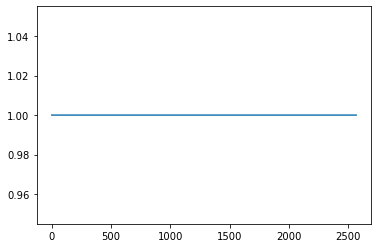

In [94]:
plt.plot(np.array(b1)/np.array(b2))
#plt.plot(b2)

### Curve fit
##### b10 (z) = 0.9 + 0.4z 
##### b20 (z) = −0.704172 − 0.207993z + 0.183023z^2 − 0.00771288z^3

In [33]:
#model = lambda kk,f,b1,b2: Bi0(kk,f,b1,b2)
model = lambda kk,f,b1,b2: Bi_wiggle(kk,f,b1,b2)

In [ ]:
k1,k2,k3=kg[:,0],kg[:,1],kg[:,2]
#r=np.array(k1*k2*k3)
b0=[65.24,352.78,38.68]
bopt, bcov = curve_fit(model,kg,bg,b0,maxfev=1000000)


In [34]:
fit=model(kg,65.24,352.78,38.68)
#print(bopt)

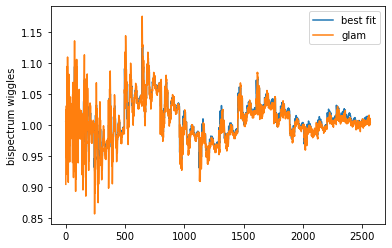

In [35]:
plt.plot(fit,label="best fit")
plt.plot(bg/bgn,label="glam")
plt.ylabel("bispectrum wiggles")
#plt.xlabel("nbins (0.01<k<0.3)")
plt.legend()

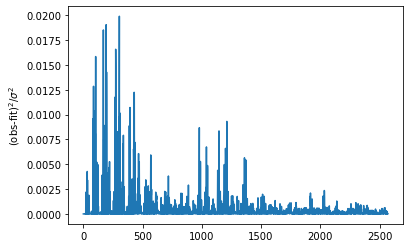

In [37]:
plt.plot(((bg/bgn)-fit)**2/np.diag(covw))
plt.ylabel("(obs-fit)$^2$/$\sigma^2$");
#plt.xlabel("nbins (0.01<k<0.105)")

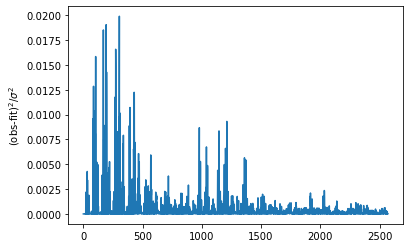

In [60]:
plt.plot(((bg/bgn)-fit)**2/np.diag(red_covw))
plt.ylabel("(obs-fit)$^2$/$\sigma^2$");
#plt.xlabel("nbins (0.01<k<0.105)")

In [ ]:
plt.plot(((bg/bgn)-fit)/(bg/bgn))

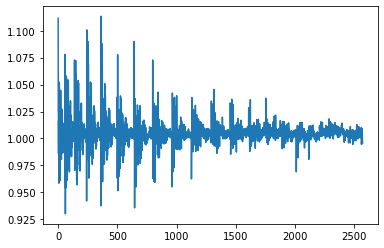

In [28]:
plt.plot(fit/(bg/bgn))

### Full Theory/Smooth Theory

In [39]:
B_full=model(kg,0.17575971,1.64549653,-0.36389956)

In [49]:
B_sm=model(kg,0.17575971,1.64549653,-0.36389956)

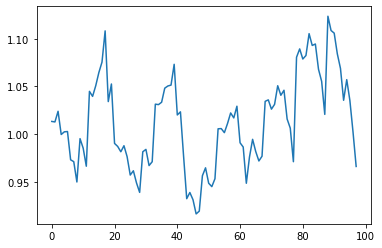

In [53]:
plt.plot(np.array(B_full)/np.array(B_sm))

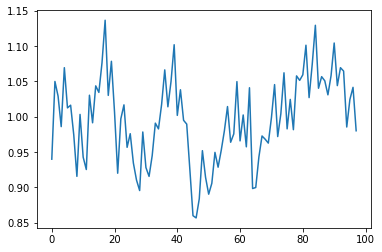

In [74]:
plt.plot(bg/bgn)
#plt.plot(pkm/pknm)

### MCMC fitting

In [29]:
model = lambda kk,alpha,f,b1,b2: Bi_wiggle(alpha*kk,f,b1,b2)*Bi0(kk,k,ps,f,b1,b2)

In [31]:
def ln_like(params, x, y, cov):
    model_y = model(x, *params)
    diff = y - model_y
    #chisq = res.dot(icov.dot(res))
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

def ln_prior(params):
    if 0<=params[0]<=1 and 2<=params[1]<=5 and -1<=params[2]<0:
        return 0.0
    return -np.inf

def ln_prob(params, x, y, cov):
    lp = ln_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_like(params, x, y, cov)

In [32]:
ndim = 3
nwalkers = 50
num_steps = 200
np.random.seed(42)
guess=[ 0.2,2.5,-0.5]
starting_params = guess + 1e-2 * np.random.randn(nwalkers,ndim)
from multiprocessing import Pool

with Pool() as pool:
    filename = "mcmc_glam_wiggle.h5"
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob,
                                    args=[kg,bg,cov],pool=pool,backend=backend)

    
    # pos, prob, state = sampler.run_mcmc(starting_params, num_steps,progress=True)
    sampler.run_mcmc(starting_params, num_steps,store=True,progress=True)

100%|██████████| 100/100 [7:13:57<00:00, 260.37s/it] 


Text(0.5, 0, 'steps')

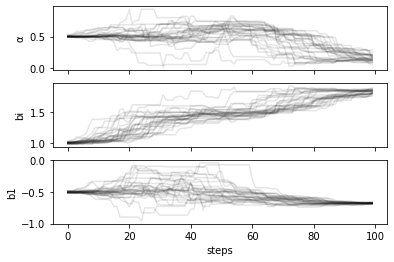

In [24]:
fig, ax = plt.subplots(ndim, sharex=True)
ylabels = ['f','b1','b2']
for i in range(ndim):
    ax[i].set_ylabel(ylabels[i])
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.1);
ax[2].set_xlabel('steps')

In [25]:
reader = emcee.backends.HDFBackend(filename)
samples = reader.get_chain(discard=85, flat=True, thin=15)

#samples = sampler.get_chain(discard=85, thin=15, flat=True)
print(samples.shape)

(30, 3)


In [26]:
samples = sampler.chain[:, :, :].reshape((-1, ndim))

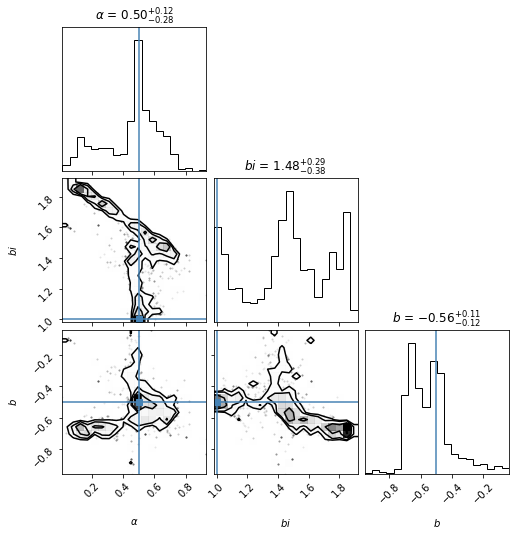

In [28]:
fig = corner.corner(samples, labels=["$\u03B1$", "$bi$", '$b$','$c$'],
                      truths=[0.5,1,-0.5],show_titles=True)

In [150]:
ans=Bi0(kg,2,4,4)

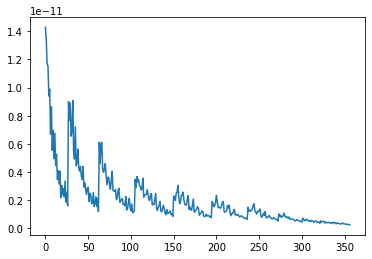

In [151]:
plt.plot(ans)

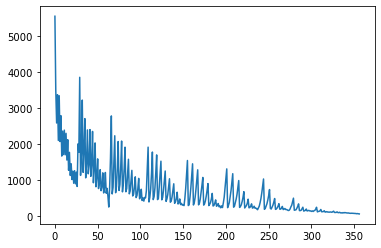

In [108]:
plt.plot(bg)

In [19]:
# b0=[]
# error=[]
# for i in tqdm(range(len(kk))):
#     k1,k2,k3=kk[i][0],kk[i][1],kk[i][2]
#     parc = 1,1,1
#     bi,err=Bi0(k1,k2,k3,parc,pars=(2000**3,1000**3))
#     b0.append(bi)
#     error.append(error)

In [53]:
kk[:,0]

array([0.005, 0.005, 0.005, ..., 0.285, 0.285, 0.295])

In [26]:
len(b0)

1600

In [41]:
def ln_prior(params,params_range):
    for i in range(len(params)):
        if params_range[i][0]<=params[i]<=params_range[i][1]:
            continue
        else:
            return -np.inf
    return 0.0

In [45]:
ln_prior([2,5,8],[[1,1],[3,9],[5,9]])

-inf

In [89]:
y = lambda phi: np.cos(phi)

In [91]:
for i in tqdm(range(1)):
    ans,error = integrate.quad(y, 0, 2*np.pi)

100%|██████████| 1/1 [00:00<00:00, 4934.48it/s]


In [92]:
ans

4.3598356225107897e-16

In [104]:
import numba as nb

In [112]:
pip install numba

You should consider upgrading via the '/global/homes/s/shreeb/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
